### Main

In [3]:
from dataloader import read_bci_data
from EEGNet import EEGNet
from DeepConvNet import DeepConvNet, ActivationLayer
import torch
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, test_loader, learning_rate, epochs, activation):
    
    model = model.to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200, verbose=True, eps=1e-2)
    # lossFn = torch.nn.CrossEntropyLoss()
    
    epoch_list = []
    train_acc_list = []
    test_acc_list = []
    
    for epoch in range(1, epochs+1):
        correct_pred = 0
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = torch.nn.functional.cross_entropy(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            # scheduler.step(loss)
            
            y_pred_binary = torch.where(y_pred[:, 0] > y_pred[:, 1], 0, 1)
            correct_pred += (y_pred_binary == y_batch).sum().item()
        train_acc = correct_pred / 1080
        train_acc_list.append(train_acc)
        
        epoch_list.append(epoch)
        val_loss, test_acc = test(model, test_loader)  
        test_acc_list.append(test_acc)
        
        if(test_acc > 0.8): torch.save(model.state_dict(), "./weights/deep_ELU")
        
        model.train()
        scheduler.step(val_loss)
         
        if epoch % 20 == 0:
            print(f"##### epoch: {epoch} | {epochs} #####")
            print(f"train_loss: {loss.item()}, train_accuracy: {correct_pred / 1080}")
            print("test accuracy: ", test_acc)    
    
    plt.plot(epoch_list, train_acc_list, label=f"{activation}_train")    
    plt.plot(epoch_list, test_acc_list, label=f"{activation}_test")
    
        
         
            
def test(model, loader):
    with torch.no_grad():
        model.eval()
        correct_pred = 0
        for x_batch, y_batch in loader:
            y_pred = model(x_batch)
            y_pred_binary = torch.where(y_pred[:, 0] > y_pred[:, 1], 0, 1)
            correct_pred += (y_pred_binary == y_batch).sum().item()
            loss = torch.nn.functional.cross_entropy(y_pred, y_batch)
            # scheduler.step(loss)
        return loss, correct_pred / 1080
        # print("accuracy: ", correct_pred / 1080)
            
    

if __name__ == "__main__":
    train_data, train_label, test_data, test_label = read_bci_data()
    train_data = torch.tensor(train_data).to(device)
    train_label = torch.tensor(train_label, dtype=torch.int64).to(device)
    test_data = torch.tensor(test_data).to(device)
    test_label = torch.tensor(test_label, dtype=torch.int64).to(device) 
    train_loader = DataLoader(TensorDataset(train_data, train_label), batch_size=1080)
    test_loader = DataLoader(TensorDataset(test_data, test_label), batch_size=1080)
    lr = 1e-2
    epochs = 300

### EGG Training 

########## Running ##########
##### epoch: 20 | 300 #####
train_loss: 0.47355999332685017, train_accuracy: 0.7574074074074074
test accuracy:  0.7111111111111111
##### epoch: 40 | 300 #####
train_loss: 0.4260466239290182, train_accuracy: 0.7962962962962963
test accuracy:  0.7342592592592593
##### epoch: 60 | 300 #####
train_loss: 0.3910085923994618, train_accuracy: 0.8194444444444444
test accuracy:  0.7518518518518519
##### epoch: 80 | 300 #####
train_loss: 0.31939006304779033, train_accuracy: 0.8583333333333333
test accuracy:  0.7907407407407407
##### epoch: 100 | 300 #####
train_loss: 0.25230290437367886, train_accuracy: 0.9018518518518519
test accuracy:  0.8055555555555556
##### epoch: 120 | 300 #####
train_loss: 0.20741343214841643, train_accuracy: 0.9092592592592592
test accuracy:  0.8175925925925925
##### epoch: 140 | 300 #####
train_loss: 0.17394854072960533, train_accuracy: 0.9259259259259259
test accuracy:  0.8212962962962963
##### epoch: 160 | 300 #####
train_loss: 0.152613597

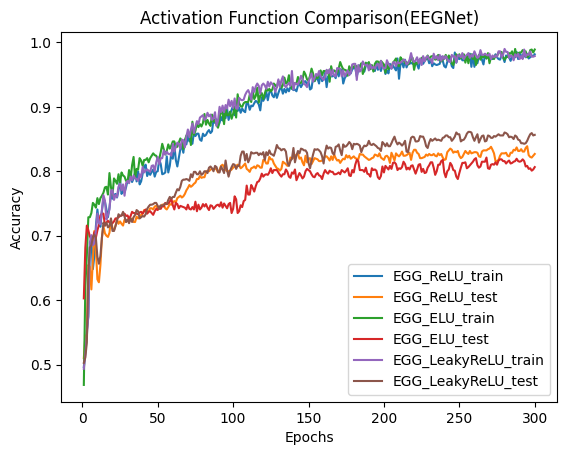

In [4]:
print("########## Running ##########")
eegnet = EEGNet(torch.nn.ReLU())
train(eegnet, train_loader, test_loader, lr, epochs, "EGG_ReLU")
torch.save(eegnet.state_dict(), "./weights/EEG_ReLU")
print("########## Finished ##########")
print("########## Running ##########")
eegnet = EEGNet(torch.nn.ELU())
train(eegnet, train_loader, test_loader, lr, epochs, "EGG_ELU")
torch.save(eegnet.state_dict(), "./weights/EEG_ELU")
print("########## Finished ##########")
print("########## Running ##########")
eegnet = EEGNet(torch.nn.LeakyReLU())
train(eegnet, train_loader, test_loader, lr, epochs, "EGG_LeakyReLU")
torch.save(eegnet.state_dict(), "./weights/EEG_LeakyReLU")
print("########## Finished ##########")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Activation Function Comparison(EEGNet)')
plt.legend()
plt.show()  

In [5]:
print(eegnet)

EEGNet(
  (firstconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ActivationLayer(
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (seperableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ActivationLayer(
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=F

### DeepConvNet Training

########## Running ##########
##### epoch: 20 | 300 #####
train_loss: 1.989812494160028, train_accuracy: 0.5138888888888888
test accuracy:  0.5231481481481481
##### epoch: 40 | 300 #####
train_loss: 0.9204904530089162, train_accuracy: 0.5166666666666667
test accuracy:  0.49537037037037035
##### epoch: 60 | 300 #####
train_loss: 0.7096168053058246, train_accuracy: 0.5990740740740741
test accuracy:  0.5824074074074074
##### epoch: 80 | 300 #####
train_loss: 0.5794022299467521, train_accuracy: 0.7129629629629629
test accuracy:  0.6509259259259259
##### epoch: 100 | 300 #####
train_loss: 0.5400733564431227, train_accuracy: 0.7175925925925926
test accuracy:  0.7194444444444444
##### epoch: 120 | 300 #####
train_loss: 0.5029340553368838, train_accuracy: 0.7444444444444445
test accuracy:  0.7203703703703703
##### epoch: 140 | 300 #####
train_loss: 0.4884635967234733, train_accuracy: 0.7472222222222222
test accuracy:  0.7361111111111112
##### epoch: 160 | 300 #####
train_loss: 0.47080981371793

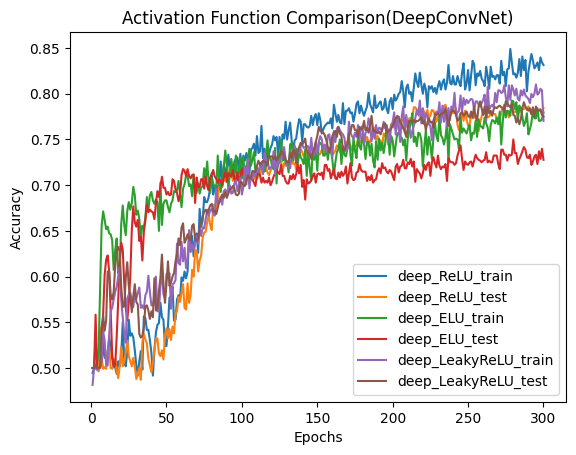

In [6]:
print("########## Running ##########")
deepConvNet1 = DeepConvNet(torch.nn.ReLU())
train(deepConvNet1, train_loader, test_loader, lr, epochs, "deep_ReLU")
torch.save(deepConvNet1.state_dict(), "./weights/deep_ReLU")
print("########## Finished ##########")
print("########## Running ##########")
deepConvNet1 = DeepConvNet(torch.nn.ELU(alpha=1.0))
train(deepConvNet1, train_loader, test_loader, lr, epochs, "deep_ELU")
torch.save(deepConvNet1.state_dict(), "./weights/deep_ELU")
print("########## Finished ##########")
print("########## Running ##########")
deepConvNet1 = DeepConvNet(torch.nn.LeakyReLU())
train(deepConvNet1, train_loader, test_loader, lr, epochs, "deep_LeakyReLU")
torch.save(deepConvNet1.state_dict(), "./weights/deep_LeakyReLU")
print("########## Finished ##########")

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Activation Function Comparison(DeepConvNet)')
plt.legend()
plt.show()  

In [7]:
print(deepConvNet1)

DeepConvNet(
  (Layer1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
    (1): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ActivationLayer(
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (Layer2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ActivationLayer(
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (Layer3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=Tru

### Highset Accuracy Model

In [8]:
# while(True):
#     epochs = 500
#     print("########## Running ##########")
#     eegnet = EEGNet(torch.nn.ReLU())
#     train(eegnet, train_loader, test_loader, lr, epochs, "EEG_ReLU")
#     # torch.save(deepConvNet1.state_dict(), "./weights/deep_ReLU")
#     print("########## Finished ##########")


In [9]:
# while(True):
#     epochs = 600
#     print("########## Running ##########")
#     deepConvNet1 = DeepConvNet(torch.nn.ELU())
#     train(deepConvNet1, train_loader, test_loader, lr, epochs, "deep_ELU")
#     # torch.save(deepConvNet1.state_dict(), "./weights/deep_ReLU")
#     print("########## Finished ##########")


### Learning Rate Comparison

########## Running ##########
##### epoch: 20 | 300 #####
train_loss: 0.6946451210501876, train_accuracy: 0.5018518518518519
test accuracy:  0.5064814814814815
##### epoch: 40 | 300 #####
train_loss: 0.6892628811026286, train_accuracy: 0.5194444444444445
test accuracy:  0.5333333333333333
##### epoch: 60 | 300 #####
train_loss: 0.6870037531675415, train_accuracy: 0.5324074074074074
test accuracy:  0.5546296296296296
##### epoch: 80 | 300 #####
train_loss: 0.6849671745896613, train_accuracy: 0.55
test accuracy:  0.5648148148148148
##### epoch: 100 | 300 #####
train_loss: 0.6145331450283196, train_accuracy: 0.6148148148148148
test accuracy:  0.5953703703703703
##### epoch: 120 | 300 #####
train_loss: 0.5760354726360659, train_accuracy: 0.6657407407407407
test accuracy:  0.6851851851851852
##### epoch: 140 | 300 #####
train_loss: 0.5514277520409414, train_accuracy: 0.7
test accuracy:  0.6972222222222222
##### epoch: 160 | 300 #####
train_loss: 0.5232516383817788, train_accuracy: 0.7388888

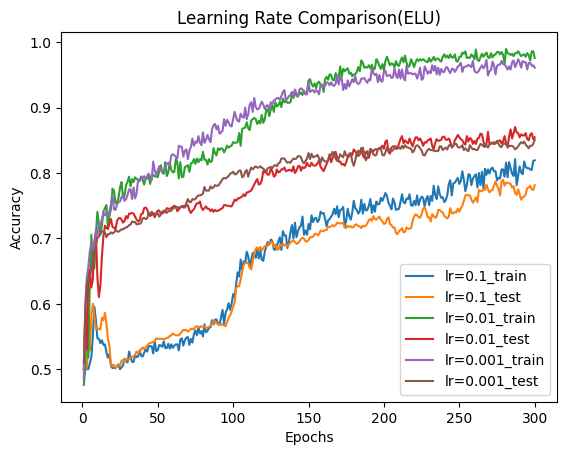

In [10]:
print("########## Running ##########")
eegnet = EEGNet(torch.nn.ReLU())
train(eegnet, train_loader, test_loader, 0.1, epochs, "lr=0.1")
torch.save(eegnet.state_dict(), "./weights/EEG_ReLU_lr01")
print("########## Finished ##########")
print("########## Running ##########")
eegnet = EEGNet(torch.nn.ReLU())
train(eegnet, train_loader, test_loader, 0.01, epochs, "lr=0.01")
torch.save(eegnet.state_dict(), "./weights/EEG_ReLU_lr001")
print("########## Finished ##########")
print("########## Running ##########")
eegnet = EEGNet(torch.nn.ReLU())
train(eegnet, train_loader, test_loader, 0.001, epochs, "lr=0.001")
torch.save(eegnet.state_dict(), "./weights/EEG_ReLU_lr0001")
print("########## Finished ##########")

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Learning Rate Comparison(ELU)')
plt.legend()
plt.show()  


## Prediction

In [11]:
model = EEGNet(torch.nn.ReLU())
model = model.to(device)
model.load_state_dict(torch.load('./weights/EEG_ReLU_874'))
test_loss, test_acc = test(model, test_loader)
print("EEG_ReLU",test_acc)

EEG_ReLU 0.8740740740740741


In [12]:
model = DeepConvNet(torch.nn.ELU())
model = model.to(device)
model.load_state_dict(torch.load('./weights/deep_ELU_814'))
test_loss, test_acc = test(model, test_loader)
print("deep_ELU", test_acc)

deep_ELU 0.8148148148148148
